First we want to isolate the cementum region. We can (hopefully) do this by performing fits to the mean intensity along the y-axis

In [1]:
%load_ext autoreload
%autoreload 2

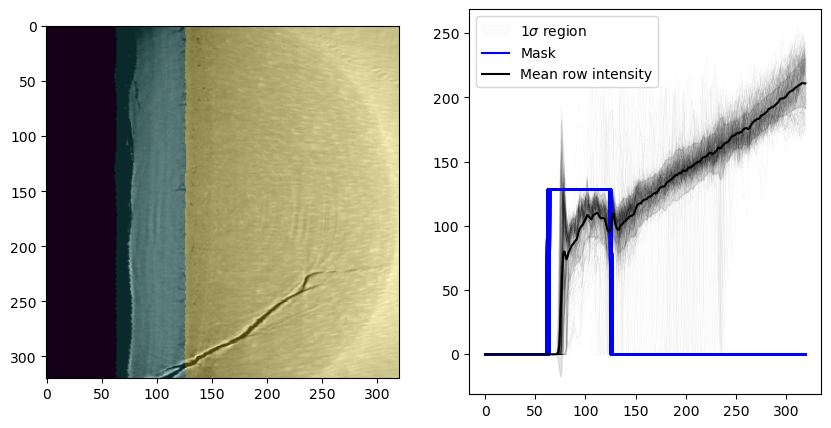

In [2]:
"""
First we'll need the straightened image and mask

"""
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

image = np.load("straightened_image.npy")
mask = np.load("straightened_mask.npy")

axes[0].imshow(image, cmap="gray")
axes[0].imshow(mask, alpha=0.3)

for im_row, mask_row in zip(image, mask):
    axes[1].plot(im_row, color="k", alpha=0.1, linewidth=0.1)
    axes[1].plot(mask_row * 128, color="b", label="mask")

axes[1].plot(np.mean(image, axis=0), color="k")

axes[1].fill_between(
    np.arange(image.shape[1]),
    np.mean(image, axis=0) - np.std(image, axis=0),
    np.mean(image, axis=0) + np.std(image, axis=0),
    color="k",
    alpha=0.1,
)

axes[1].legend(
    handles=[
        Patch(color="k", alpha=0.01),
        Line2D([], [], color="b"),
        Line2D([], [], color="k"),
    ],
    labels=[rf"1$\sigma$ region", "Mask", "Mean row intensity"],
)

img_dir = "img/normalise_contrast"
if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

fig.savefig(f"{img_dir}/intensity_profile.png")

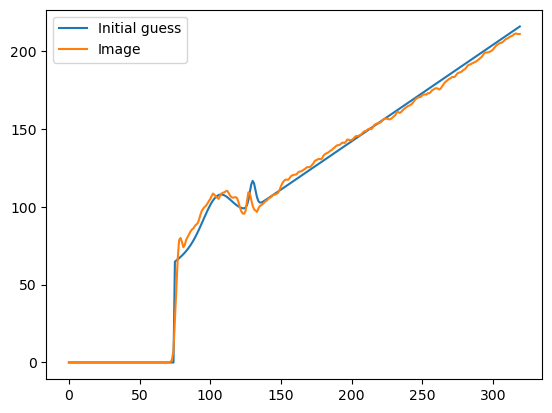

In [3]:
"""
We can try to fit a function to it that gives the positions of the start and end of the cementum region

There will be a constant, a wide Gaussian for the inside of the cementum region, a narrow gaussian for the end of the cementum region 

"""
from scipy.stats import norm

from cementum import fit_cementum_extra_peak, fit_cementum

# Just plot it for now so we can see what it looks like
x = np.arange(image.shape[0])

# initial_guess = [75, 18, 50, 3, 2, 600, 22, 10, 85, 27, 2, 0.62]
initial_guess = [75, 18, 600, 30, 10, 85, 25, 2, 0.62]

y = fit_cementum.fit_fcn(x, *initial_guess)

plt.plot(x, y, label="Initial guess")
plt.plot(x, np.mean(image, axis=0), label="Image")

plt.legend()
plt.savefig(f"{img_dir}/fit_fcn.png")

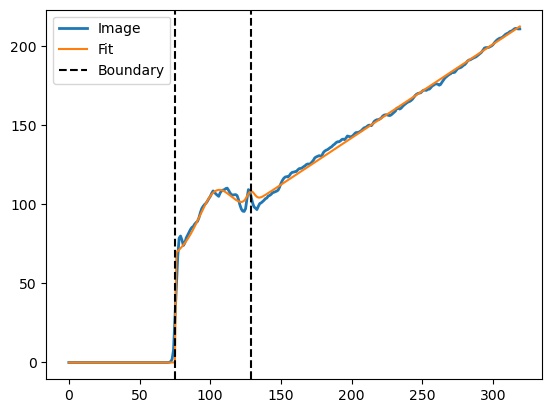

In [4]:
"""
Fit to the mean intensity across the rows

"""
popt = fit_cementum._fit_curve(x, np.mean(image, axis=0), initial_guess)

plt.plot(x, np.mean(image, axis=0), label="Image", linewidth=2)
plt.plot(x, fit_cementum.fit_fcn(x, *popt), label="Fit", linewidth=1.5)

a, d1, d2 = [popt[i] for i in [0, 3, 6]]
start, end = a, a + d1 + d2

plt.axvline(start, color="k", linestyle="--", label="Boundary")
plt.axvline(end, color="k", linestyle="--")

plt.legend()

plt.savefig(f"{img_dir}/one_image_fit.png")

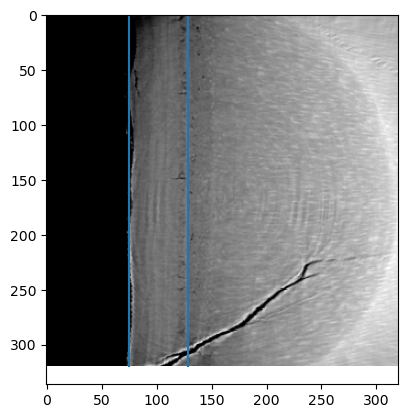

In [5]:
"""
Show the fitted edges on the image

"""

plt.imshow(image, cmap="gray")
plt.vlines(start, 0, image.shape[0])
plt.vlines(end, 0, image.shape[0])

plt.savefig(f"{img_dir}/one_image_fit_on_image.png")

Next we want to remove any noise from the columns. We expect the columns to closely follow the layers, so we will remove any peaking noise from them.

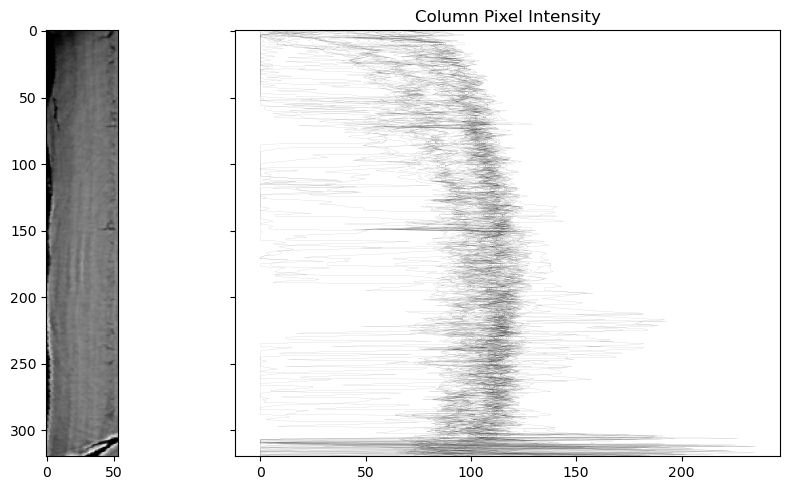

In [6]:
"""
Plot the intensity along columns of the cropped image

"""
import os

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Crop the image
cropped_image = image[:, int(start) : int(end) + 1]
axes[0].imshow(cropped_image, cmap="grey")

x = np.arange(cropped_image.shape[0])
for column in cropped_image.T:
    axes[1].plot(column, x, color="k", alpha=0.4, linewidth=0.1)
axes[1].set_title("Column Pixel Intensity")

fig.tight_layout()
fig.savefig(f"{img_dir}/cropped_intensity.png", bbox_inches="tight")


You can (sort of?) see the two different types of layer in this image. We might want to remove the curve:

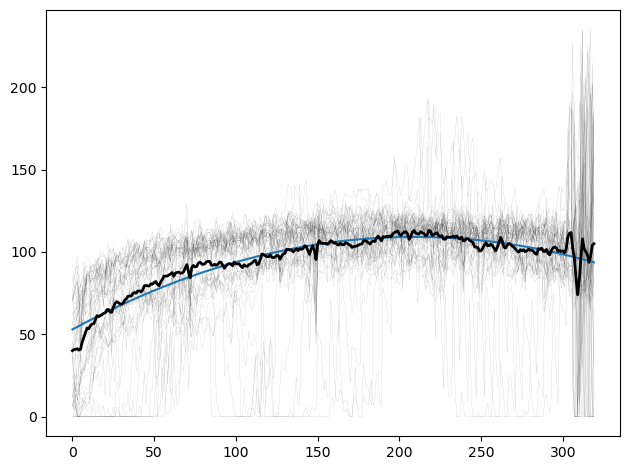

In [7]:
"""
Fit a polynomial to the average columns

"""
fig, axis = plt.subplots()

deg = 2
x = np.arange(cropped_image.shape[0])

for column in cropped_image.T:
    axis.plot(x, column, color="k", alpha=0.4, linewidth=0.1)

coefs = np.polyfit(x, np.mean(cropped_image, axis=1), deg=deg)
poly_vals = np.polyval(coefs, x)
axis.plot(x, poly_vals)
axis.plot(x, np.mean(cropped_image, axis=1), color="k", linewidth=2)

fig.tight_layout()
fig.savefig(f"{img_dir}/intensity_fit.png", bbox_inches="tight")

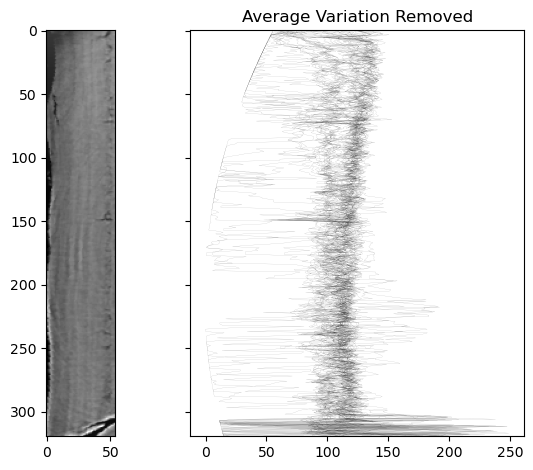

In [8]:
"""
Flatten the curves!

"""
fig, axes = plt.subplots(1, 2, sharey=True)

# Remove the mean from each column, but don't remove the constant term
# Enure the intensity doesn't go below 0
normalised_image = cropped_image - np.polyval(coefs, x).reshape(-1, 1) + coefs[-1]
normalised_image -= normalised_image.min()

axes[0].imshow(normalised_image, cmap="grey")
for column in normalised_image.T:
    axes[1].plot(column, x, color="k", alpha=0.4, linewidth=0.1)

axes[1].set_title("Average Variation Removed")

fig.tight_layout() 
fig.savefig(f"{img_dir}/columns_noise_removed.png", bbox_inches="tight")


We may want to perform contrast normalisation here: create a histogram of the intensity, it should be bimodal

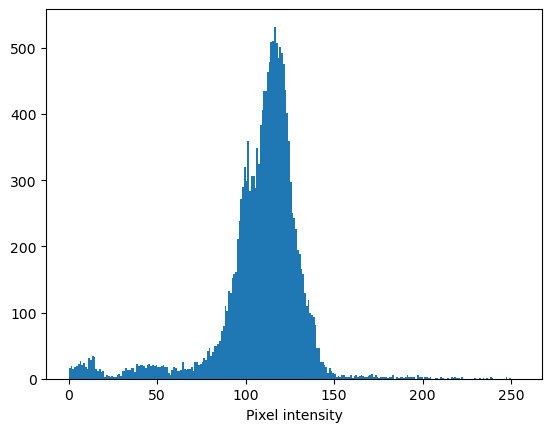

In [9]:
"""
Histogram of pixel intensities

"""
fig, axis = plt.subplots()
_ = axis.hist(normalised_image.flat, bins=np.arange(256))
axis.set_xlabel("Pixel intensity")

fig.savefig(f"{img_dir}/normalised_pixels_hist.png")

/home/mh19137/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


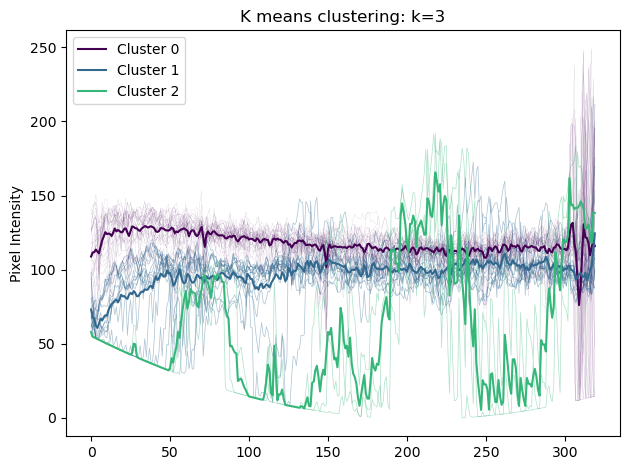

In [10]:
"""
K-means clustering on the columns

"""
from sklearn.cluster import KMeans

n_clusters = 3
cluster = KMeans(n_clusters=n_clusters, random_state=0, max_iter=1000).fit(
    normalised_image.T
)

fig, axis = plt.subplots()
cmap = plt.get_cmap("viridis", lut=10)
for label, column in zip(cluster.labels_, normalised_image.T):
    axis.plot(
        x,
        column,
        color=cmap(label / n_clusters),
        alpha=0.4,
        linewidth=0.5 if label else 0.1,
    )

for i, (label, centre) in enumerate(zip(range(n_clusters), cluster.cluster_centers_)):
    axis.plot(x, centre, color=cmap(label / n_clusters), label=f"Cluster {i}")

axis.set_title(f"K means clustering: k={n_clusters}")
axis.set_ylabel("Pixel Intensity")

axis.legend()

fig.tight_layout()
fig.savefig(f"{img_dir}/kmeans.png")

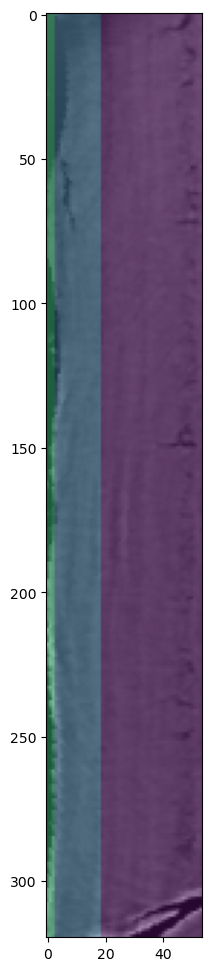

In [11]:
fig, axis = plt.subplots(figsize=(4, 12))

coloured_image = np.zeros((*normalised_image.shape, 3))
colours = np.array([cmap(i / n_clusters) for i in range(n_clusters)])[:, :3]

# Set each column to its corresponding color
for x, label in zip(np.arange(normalised_image.shape[1]), cluster.labels_):
    coloured_image[:, x] = colours[label]

# Display the colored image
axis.imshow(normalised_image, cmap="grey")
axis.imshow(coloured_image, alpha=0.5)

fig.savefig(f"{img_dir}/clustered_image.png")

Let's try instead normalising the contrast horizonally...

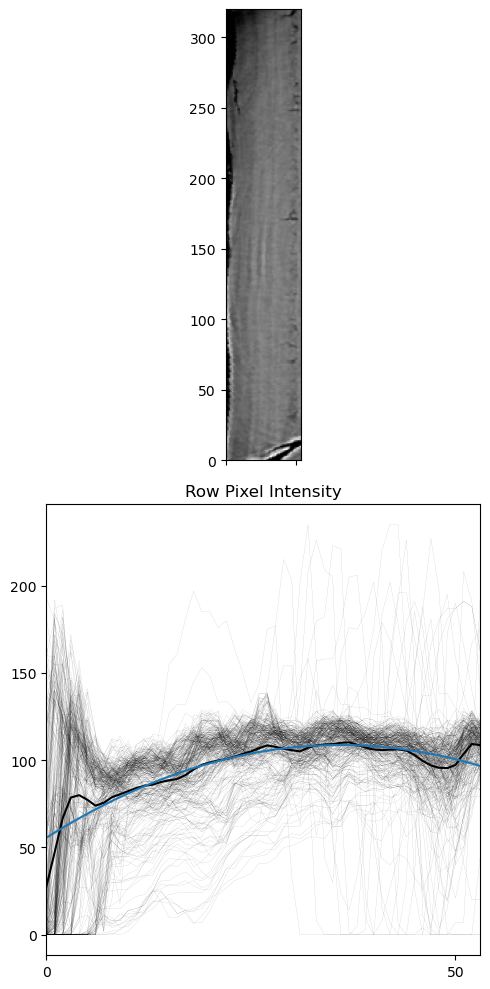

In [12]:
"""
Plot the intensity along rows

"""
fig, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)

x = np.arange(cropped_image.shape[1])
axes[0].imshow(
    cropped_image, cmap="grey", extent=[x.min(), x.max(), 0, cropped_image.shape[0]]
)

for row in cropped_image:
    axes[1].plot(x, row, color="k", alpha=0.4, linewidth=0.1)
axes[1].plot(x, np.mean(cropped_image, axis=0), color="k")
axes[1].set_title("Row Pixel Intensity")
                  
deg = 2
coefs = np.polyfit(x, np.mean(cropped_image, axis=0), deg=deg)
poly_vals = np.polyval(coefs, x)
axes[1].plot(x, poly_vals)

fig.tight_layout()

fig.tight_layout()
fig.savefig(f"{img_dir}/cropped_rows.png", bbox_inches="tight")

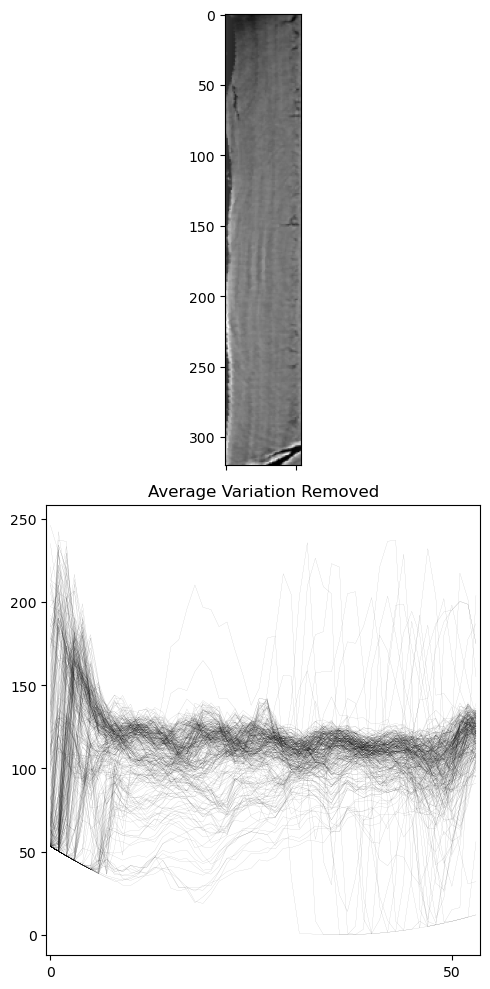

In [13]:
"""
Remove the non-constant part of the polynomial

"""
fig, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)

# Remove the mean from each column, but don't remove the constant term
# Enure the intensity doesn't go below 0
normalised_image = cropped_image - np.polyval(coefs, x) + coefs[-1]
normalised_image -= normalised_image.min()

axes[0].imshow(normalised_image, cmap="grey")
for row in normalised_image:
    axes[1].plot(x, row, color="k", alpha=0.4, linewidth=0.1)

axes[1].set_title("Average Variation Removed")

fig.tight_layout()
fig.savefig(f"{img_dir}/rows_noise_removed.png", bbox_inches="tight")

/home/mh19137/miniforge3/envs/tf2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


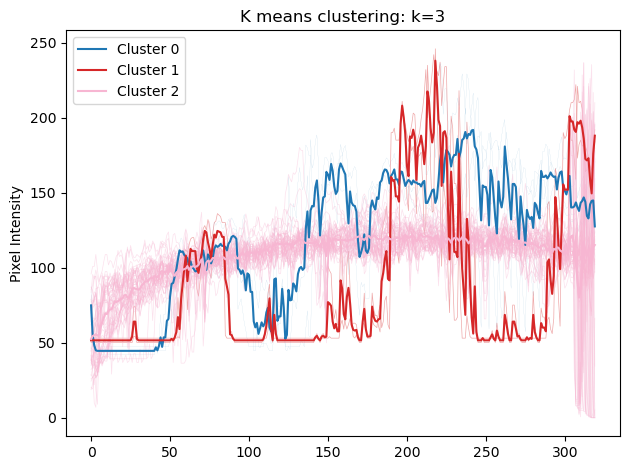

In [14]:
"""
Now let's try k-means-clustering on the columns

"""
n_clusters = 3
cluster = KMeans(n_clusters=n_clusters, random_state=0, max_iter=1000).fit(
    normalised_image.T
)

fig, axis = plt.subplots()
x = np.arange(cropped_image.shape[0])
cmap = plt.get_cmap("tab20", lut=10)
for label, column in zip(cluster.labels_, normalised_image.T):
    axis.plot(
        x,
        column,
        color=cmap(label / n_clusters),
        alpha=0.4,
        linewidth=0.5 if label else 0.1,
    )

for i, (label, centre) in enumerate(zip(range(n_clusters), cluster.cluster_centers_)):
    axis.plot(x, centre, color=cmap(label / n_clusters), label=f"Cluster {i}")

axis.set_title(f"K means clustering: k={n_clusters}")
axis.set_ylabel("Pixel Intensity")

axis.legend()

fig.tight_layout()
fig.savefig(f"{img_dir}/kmeans_row_smoothed.png")

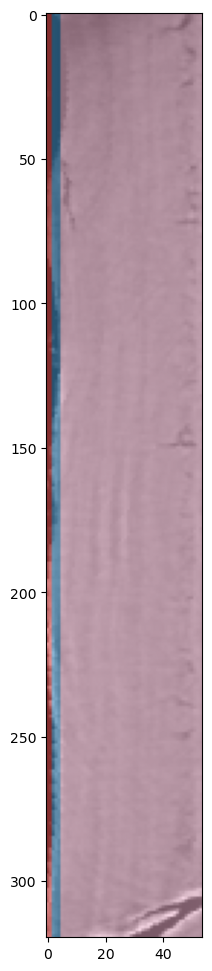

In [15]:
fig, axis = plt.subplots(figsize=(4, 12))

coloured_image = np.zeros((*normalised_image.shape, 3))
colours = np.array([cmap(i / n_clusters) for i in range(n_clusters)])[:, :3]

# Set each column to its corresponding color
for x, label in zip(np.arange(normalised_image.shape[1]), cluster.labels_):
    coloured_image[:, x] = colours[label]

# Display the colored image
axis.imshow(normalised_image, cmap="grey")
axis.imshow(coloured_image, alpha=0.5)

fig.savefig(f"{img_dir}/clustered_image.png")

Now that we have removed the noise from the columns, we can apply a vertical Gaussian filter that will help to distinguish the edges.

Now that we've increased the contrast between columns, we can perform fits to isolate the increments